In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# #한글 폰트 다운로드 

# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [3]:
import matplotlib.pyplot as plt

# plt.rc('font', family='NanumBarunGothic')

In [4]:
import os
import zipfile

import numpy as np
import math
from IPython.display import Image

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

#GPU 메모리 제한
config = tf.compat.v1.ConfigProto(
    gpu_options=tf.compat.v1.GPUOptions(
        per_process_gpu_memory_fraction=0.80 #최대치의 45%까지
    )
)
sess = sess = tf.compat.v1.Session(config=config)

print(tf.__version__)

2.10.0


Image Generator 정의

In [5]:
#ImageDataGenerator

training_datagen = ImageDataGenerator(
    rescale=1. / 255,        #rescale: 이미지의 픽셀 값을 조정
    rotation_range = 20,     #rotation_range: 이미지 회전
    width_shift_range=0.2,   #width_shift_range: 가로 방향으로 이동
    height_shift_range=0.2,  #height_shift_range: 세로 방향으로 이동
    shear_range = 0.2,         #shear_range: 이미지 굴절
    zoom_range = [0.8, 1.4],        #zoom_range: 이미지 확대
    horizontal_flip = False,  #horizontal_flip: 횡 방향으로 이미지 반전
    fill_mode = 'nearest',   #fill_mode: 이미지를 이동이나 굴절시켰을 때 빈 픽셀 값에 대하여 값을 채우는 방식
    validation_split=0.2,    #validat/ion_split: validation set의 구성 비율
    )

#학습 모델 평가를 위함
test_datagen = ImageDataGenerator(
    rescale=1. / 255,        #rescale: 이미지의 픽셀 값을 조정
    )

training_generator에 대한 from_from_directory를 정의합니다.

* `rescale`: 이미지의 픽셀 값을 조정
* `rotation_range`: 이미지 회전
* `width_shift_range`: 가로 방향으로 이동
* `height_shift_range`: 세로 방향으로 이동
* `shear_range`: 이미지 굴절
* `zoom_range`: 이미지 확대
* `horizontal_flip`: 횡 방향으로 이미지 반전
* `fill_mode`: 이미지를 이동이나 굴절시켰을 때 빈 픽셀 값에 대하여 값을 채우는 방식
* `validation_split`: validation set의 구성 비율

In [6]:
# #폴더(디렉토리 삭제 함수)

# import shutil

# def DeleteAllFiles(filePath):
#     if os.path.exists(filePath):
#         for file in os.scandir(filePath):
#             os.remove(file.path)
#     else:
#         os.makedirs(filePath)
#         return 'Directory not Found and make director'  

In [7]:
# dir
TRAINING_DIR = "D:/문서/우영웅/도로공사AI경진대회/data/train_200/"  
TEST_DIR = "D:/문서/우영웅/도로공사AI경진대회/data/test/"  
TEST2_DIR = "D:/문서/우영웅/도로공사AI경진대회/data/test_balanced/" 
image_file_path = 'D:/문서/우영웅/도로공사AI경진대회/data/'
model_file_path = 'D:/문서/우영웅/도로공사AI경진대회/model/'
checkpoint_path = 'D:/문서/우영웅/도로공사AI경진대회/checkpoint/' + "tmp_checkpoint_200.ckpt"

# 학습조건
batch_size = 32 #배치 크기 32 best

In [8]:
# print(DeleteAllFiles(TRAINING_DIR))   

In [9]:
#압축풀기
# local_zip = 'train_data_reduce.zip' 
# image_file_path = '/content/drive/MyDrive/Colab Notebooks/표지판 인식 대회/data/'
# zip_ref = zipfile.ZipFile(image_file_path+local_zip, 'r')
# zip_ref.extractall(image_file_path)
# zip_ref.close()

In [10]:
# Train data generator
# 여기서 batch_size의 값은 성능을 좌우하므로 최적으로 바꾸어야 함
training_generator = training_datagen.flow_from_directory(TRAINING_DIR, 
                                                          batch_size=batch_size, 
                                                          target_size=(150, 150), 
                                                          class_mode='categorical', 
                                                          subset='training',
                                                         )

Found 12437 images belonging to 100 classes.


In [11]:
# Validation data generator
# 여기서 batch_size의 값은 성능을 좌우하므로 최적으로 바꾸어야 함
validation_generator = training_datagen.flow_from_directory(TRAINING_DIR, 
                                                            batch_size=batch_size, 
                                                            target_size=(150, 150), 
                                                            class_mode='categorical',
                                                            subset='validation', 
                                                          )

Found 3091 images belonging to 100 classes.


In [12]:
# Test data generator
# 여기서 batch_size의 값은 성능을 좌우하므로 최적으로 바꾸어야 함
test_generator = test_datagen.flow_from_directory(TEST_DIR, 
                                                    batch_size=batch_size, 
                                                    target_size=(150, 150), 
                                                    class_mode='categorical', 
                                                    shuffle=False,
                                                          )

test_generator2 = test_datagen.flow_from_directory(TEST2_DIR, 
                                                    batch_size=batch_size, 
                                                    target_size=(150, 150), 
                                                    class_mode='categorical', 
                                                    shuffle=False,
                                                          )


Found 104312 images belonging to 100 classes.
Found 1030 images belonging to 100 classes.


# traing image의 시각화

In [13]:
# import matplotlib.pyplot as plt

# # #출력 을 정하기 위해서 맵핑을  합니다.
# # #폴더의수에 따라서 맵핑은 바꾸어져야 함
# class_map = {
#     0: '216',
#     1: '227', 
#     2: '305', 
#     3: '306', 
#     4: '307', 
#     5: '311', 
# }

# # print('오리지널 사진 파일')

# # original_datagen = ImageDataGenerator(rescale=1./255)
# # original_generator = original_datagen.flow_from_directory(TRAINING_DIR, 
# #                                                           batch_size=10, 
# #                                                           target_size=(150, 150), 
# #                                                           class_mode='categorical'
# #                                                          )

# # for x, y in original_generator:
# #     print(x.shape, y.shape)
# #     print(y[0])
    
# #     fig, axes = plt.subplots(2, 5)
# #     fig.set_size_inches(15, 6)
# #     for i in range(10):
# #         axes[i//5, i%5].imshow(x[i])
# #         axes[i//5, i%5].set_title(class_map[y[i].argmax()], fontsize=15)
# #         axes[i//5, i%5].axis('off')
# #     plt.show()
# #     break
    
# print('Image Augmentation 적용한 사진 파일- Imager Generator로 만든 이미지')
    
# count = 1    
# for x, y in training_generator:
#     print(x.shape, y.shape)
#     print(y[0])
    
#     fig, axes = plt.subplots(2, 5)
#     fig.set_size_inches(15, 6)
#     for i in range(10):
#         axes[i//5, i%5].imshow(x[i])
#         #axes[i//5, i%5].set_title(class_map[y[i].argmax()], fontsize=15)
#         axes[i//5, i%5].axis('off')
    
#     plt.show()
#     if count >= 5:
#         break
#     else:
#         count += 1
        
# # print('Test 사진 파일- 수업 샘플')

# # for x, y in test_generator:
# #     print(x.shape, y.shape)
# #     print(y[0])
    
# #     fig, axes = plt.subplots(2, 5)
# #     fig.set_size_inches(15, 6)
# #     for i in range(10):
# #         axes[i//5, i%5].imshow(x[i])
# #         axes[i//5, i%5].set_title(class_map[y[i].argmax()], fontsize=15)
# #         axes[i//5, i%5].axis('off')
    
# #     plt.show()
# #     break

#신경회로망 모델 정의

In [14]:
activation = 'ReLU'

model = Sequential([
    # Conv2D, MaxPooling2D 조합으로 층을 쌓습니다. 첫번째 입력층의 input_shape은 (640, 230, 3)으로 지정합니다.
    Conv2D(64, (2, 2), activation=activation, input_shape=(150, 150, 3)),
    Conv2D(64, (3, 3), activation=activation), 
    MaxPooling2D(2, 2), 
    
    #여기서 부터 Convolition 회로망의 layer 수와 node  수를 정의 해야 합니다.
    
    Conv2D(96, (2, 2), activation=activation ), 
    Conv2D(96, (3, 3), activation=activation),
    MaxPooling2D(2, 2), 
    Conv2D(128, (2, 2), activation=activation),
    Conv2D(128, (3, 3), activation=activation),
    MaxPooling2D(2, 2), 
    Conv2D(160, (2, 2), activation=activation),
    Conv2D(160, (3, 3), activation=activation),
    MaxPooling2D(3, 3), 



    # 2D -> 1D로 변환을 위하여 Flatten 합니다.
    Flatten(), 
    # 과적합 방지를 위하여 Dropout을 적용합니다.
    Dropout(0.2),
    #Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    #Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    
    # Classification을 위한 Softmax 
    Dense(100, activation='softmax'),   
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 149, 149, 64)      832       
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 72, 72, 96)        24672     
                                                                 
 conv2d_3 (Conv2D)           (None, 70, 70, 96)        83040     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 35, 35, 96)       0         
 2D)                                                    

#신경회로망 모델 컴파일

In [15]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

# ModelCheckpoint: 체크포인트 생성

In [16]:

checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

# 신경회로망 학습 

In [17]:
epochs = 500 #학습 회수 선정

checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=0)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(training_generator, 
                    validation_data=(validation_generator),
                    epochs=epochs,
                    callbacks=[checkpoint],
                    #verbose=2,
                    )

Epoch 1/500
389/389 [==============================] - 314s 799ms/step - loss: 3.9008 - acc: 0.0495 - val_loss: 3.4469 - val_acc: 0.0941
Epoch 2/500
389/389 [==============================] - 68s 175ms/step - loss: 3.1410 - acc: 0.1479 - val_loss: 2.9694 - val_acc: 0.1876
Epoch 3/500
389/389 [==============================] - 70s 179ms/step - loss: 2.7191 - acc: 0.2452 - val_loss: 2.6308 - val_acc: 0.2659
Epoch 4/500
389/389 [==============================] - 71s 183ms/step - loss: 2.4236 - acc: 0.3236 - val_loss: 2.4954 - val_acc: 0.2954
Epoch 5/500
389/389 [==============================] - 71s 181ms/step - loss: 2.2301 - acc: 0.3681 - val_loss: 2.2853 - val_acc: 0.3403
Epoch 6/500
389/389 [==============================] - 71s 182ms/step - loss: 2.0613 - acc: 0.4059 - val_loss: 2.0676 - val_acc: 0.3785
Epoch 7/500
389/389 [==============================] - 70s 181ms/step - loss: 1.8740 - acc: 0.4584 - val_loss: 1.8943 - val_acc: 0.4474
Epoch 8/500
389/389 [==========================

#학습 완료 후 Load Weights (ModelCheckpoint)

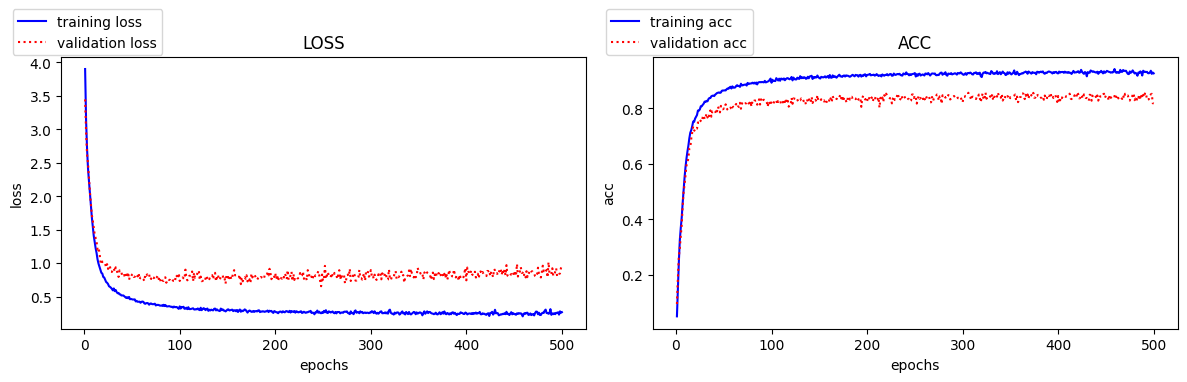

In [18]:
#학습 과정 시각화
def vis(history,name) :
    plt.title(f"{name.upper()}")
    plt.xlabel('epochs')
    plt.ylabel(f"{name.lower()}")
    value = history.history.get(name)
    val_value = history.history.get(f"val_{name}",None)
    epochs = range(1, len(value)+1)
    plt.plot(epochs, value, 'b-', label=f'training {name}')
    if val_value is not None :
        plt.plot(epochs, val_value, 'r:', label=f'validation {name}')
    plt.legend(loc='upper center', bbox_to_anchor=(0.05, 1.2) , fontsize=10 , ncol=1)
    
def plot_history(history) :
    
    key_value = list(set([i.split("val_")[-1] for i in list(history.history.keys())]))
    plt.figure(figsize=(12, 4))
    for idx , key in enumerate(key_value) :
        plt.subplot(1, len(key_value), idx+1)
        vis(history, key)
    plt.tight_layout()
    plt.show()
    
plot_history(history)

In [19]:
# model = tf.keras.models.load_model('D:/문서/우영웅/도로공사AI경진대회/model/221113_Epoch_100_Batch_128_Model_basic_Data_full.h5')

In [20]:
model.load_weights(checkpoint_path)

In [21]:
# model.evaluate(test_generator) 
model.evaluate(test_generator2)

33/33 [==============================] - 10s 316ms/step - loss: 0.6691 - acc: 0.9039


[0.6691015958786011, 0.9038835167884827]

In [22]:
model.save(model_file_path+f"221119_Epoch_{epochs}_Batch_{batch_size}_Model_basic_Data_200_100class.h5")